In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

In [4]:
# Graph aesthetics settings
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from cycler import cycler
import seaborn as sns
large = 20; medium = 16; small = 12
# To change the color scheme
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ab']
text_color = "#333333"

params = {'axes.titlesize': medium,
          'legend.fontsize': small,
          'figure.figsize': (8,5),
          'axes.labelsize': small,
          'axes.linewidth': 2,
          'xtick.labelsize': small,
          'xtick.color': text_color,
          'ytick.color': text_color,
          'ytick.labelsize': small,
          'axes.edgecolor': text_color,
          'figure.titlesize': small,
          'axes.prop_cycle': cycler(color=colors),
          'axes.titlecolor': text_color,
          'axes.labelcolor': text_color,
         }

plt.rcParams.update(params)

In [5]:
df = pd.read_excel("Online Retail.xlsx")

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# Precprocessing/Data cleaning
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df_uk = df[df['Country'] == 'United Kingdom']
basket = df_uk.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [8]:
# Finding associations
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values('lift', ascending=False)
print(rules.head())

/opt/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


    antecedents consequents  antecedent support  consequent support   support  \
506     (22916)     (22917)            0.010751            0.010872  0.010151   
507     (22917)     (22916)            0.010872            0.010751  0.010151   
511     (23171)     (23170)            0.013634            0.015977  0.011532   
510     (23170)     (23171)            0.015977            0.013634  0.011532   
482     (22745)     (22746)            0.015617            0.012553  0.010151   

     confidence       lift  leverage  conviction  zhangs_metric  
506    0.944134  86.844687  0.010034   17.705400       0.999228  
507    0.933702  86.844687  0.010034   14.921166       0.999350  
511    0.845815  52.939750  0.011314    6.382092       0.994672  
510    0.721805  52.939750  0.011314    3.545584       0.997040  
482    0.650000  51.779187  0.009955    2.821276       0.996245  


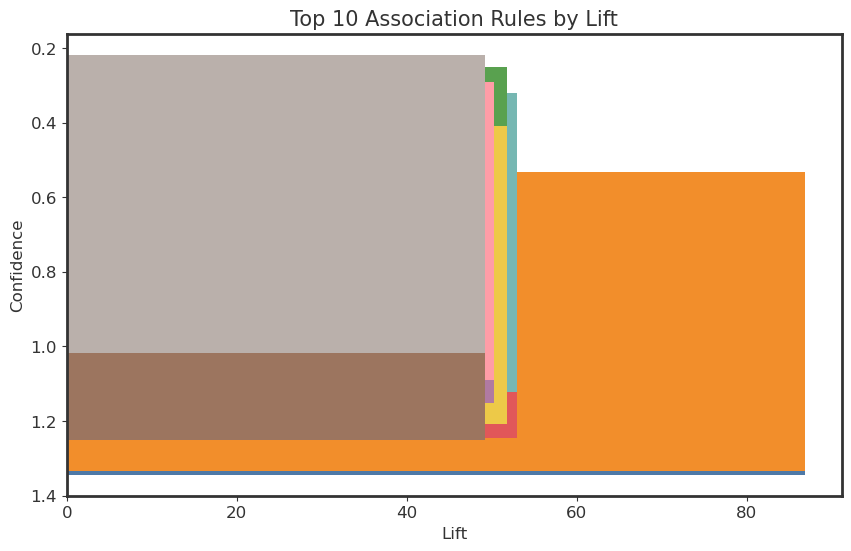

In [9]:
# looks useless to me, but just in case this is useful, I included this
plt.figure(figsize=(10, 6))
bars = plt.barh(rules.head(10)['confidence'], rules.head(10)['lift'], color=colors[:10])
plt.xlabel('Lift', fontsize=12)
plt.ylabel('Confidence', fontsize=12)
plt.title('Top 10 Association Rules by Lift', fontsize=15)
plt.gca().invert_yaxis()  
plt.show()

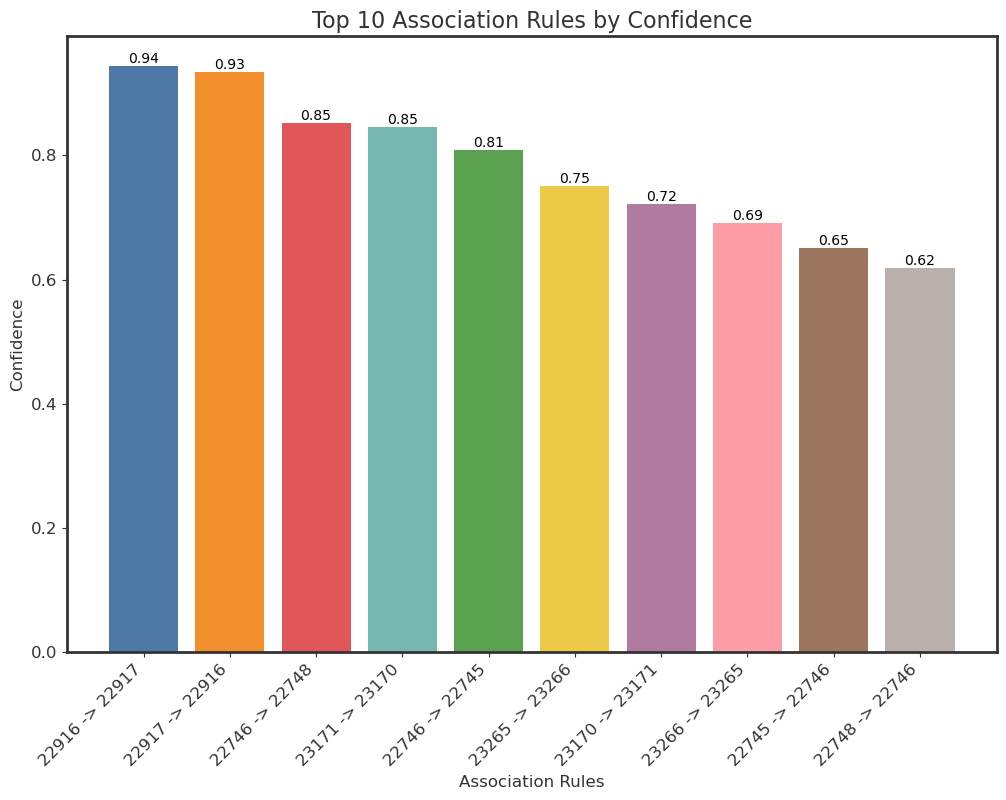

In [10]:
top_rules = rules.head(10).sort_values(by='confidence', ascending=False)
rule_labels = [f'{list(rule["antecedents"])[0]} -> {list(rule["consequents"])[0]}' for _, rule in top_rules.iterrows()]

plt.figure(figsize=(12, 8))
bars = plt.bar(rule_labels, top_rules['confidence'], color=colors[:10])

plt.xlabel('Association Rules')
plt.ylabel('Confidence')
plt.title('Top 10 Association Rules by Confidence')
plt.xticks(rotation=45, ha='right')

for bar, confidence in zip(bars, top_rules['confidence']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{confidence:.2f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Sparse

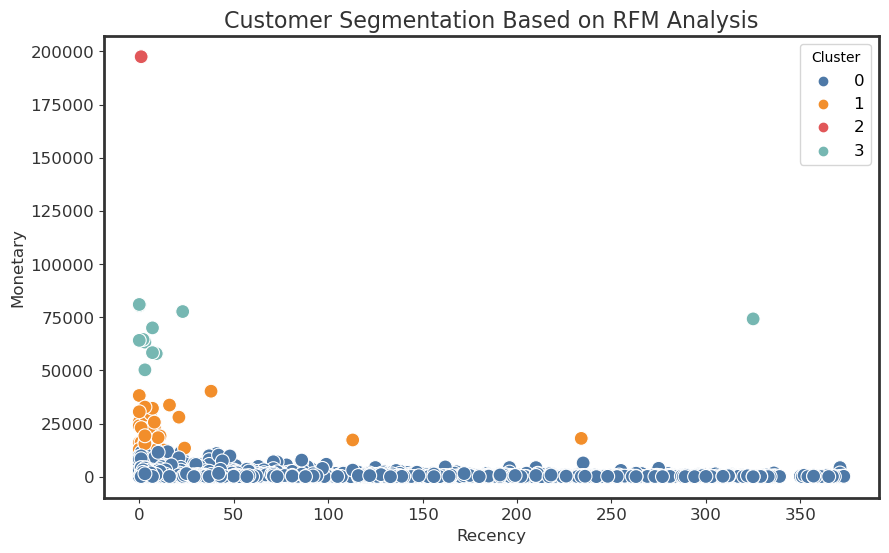

In [11]:
# RFM Analysis
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
    'InvoiceNo': 'count',
    'Quantity': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Clustering
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']]
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Plotting the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette=colors[:4], s=100)
plt.title('Customer Segmentation Based on RFM Analysis')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()